Jumlah koin terdeteksi (manual): 153


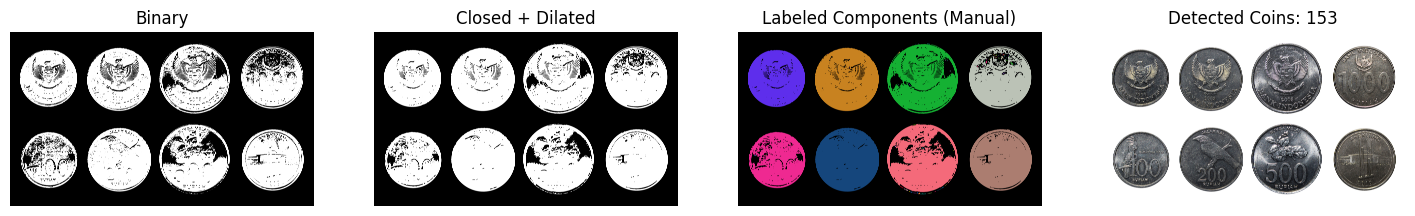

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image_path = "tests/test1.png"  # Path ke gambar
image = cv2.imread(image_path)

if image is None:
  raise FileNotFoundError(f"Image not found at the path: {image_path}")

# 1️⃣ Grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# 2️⃣ Gaussian Blur untuk reduksi noise
blur = cv2.GaussianBlur(gray, (15, 15), 0)

# 3️⃣ Threshold manual (biner)
_, binary = cv2.threshold(blur, 120, 255, cv2.THRESH_BINARY_INV)

# 4️⃣ Morphological closing (manual pakai kernel)
kernel_large = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
closed = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel_large, iterations=1)

# 5️⃣ Dilation untuk memperjelas koin
kernel_small = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
dilated = cv2.dilate(closed, kernel_small, iterations=1)

# 6️⃣ Denoising pakai median blur
final = cv2.medianBlur(dilated, 5)

# 7️⃣ --- Connected Component Labeling (Manual) ---
# Kita buat algoritma flood-fill sederhana untuk menghitung objek putih

def manual_connected_components(binary_img):
  img = (binary_img > 0).astype(np.uint8)  # ubah ke 0/1
  h, w = img.shape
  label = np.zeros((h, w), dtype=np.int32)
  current_label = 0
  directions = [(-1,0),(1,0),(0,-1),(0,1),(-1,-1),(-1,1),(1,-1),(1,1)]  # 8 arah

  for y in range(h):
    for x in range(w):
      if img[y, x] == 1 and label[y, x] == 0:
        current_label += 1
        stack = [(y, x)]
        while stack:
          cy, cx = stack.pop()
          if label[cy, cx] == 0:
            label[cy, cx] = current_label
            for dy, dx in directions:
              ny, nx = cy + dy, cx + dx
              if 0 <= ny < h and 0 <= nx < w:
                if img[ny, nx] == 1 and label[ny, nx] == 0:
                  stack.append((ny, nx))
  return label, current_label

# Jalankan fungsi
labels, coin_count = manual_connected_components(final)

print(f"Jumlah koin terdeteksi (manual): {coin_count}")

# 8️⃣ Warnai setiap komponen untuk visualisasi
colored_label = np.zeros((*labels.shape, 3), dtype=np.uint8)
rng = np.random.default_rng(42)
for i in range(1, coin_count + 1):
  color = rng.integers(0, 255, size=3)
  colored_label[labels == i] = color

# 9️⃣ Tampilkan hasil
plt.figure(figsize=(18, 12))
plt.subplot(1, 4, 1)
plt.title("Binary")
plt.imshow(binary, cmap="gray")
plt.axis("off")

plt.subplot(1, 4, 2)
plt.title("Closed + Dilated")
plt.imshow(dilated, cmap="gray")
plt.axis("off")

plt.subplot(1, 4, 3)
plt.title("Labeled Components (Manual)")
plt.imshow(colored_label)
plt.axis("off")

plt.subplot(1, 4, 4)
plt.title(f"Detected Coins: {coin_count}")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

Jumlah koin terdeteksi (area dominan adaptif): 2


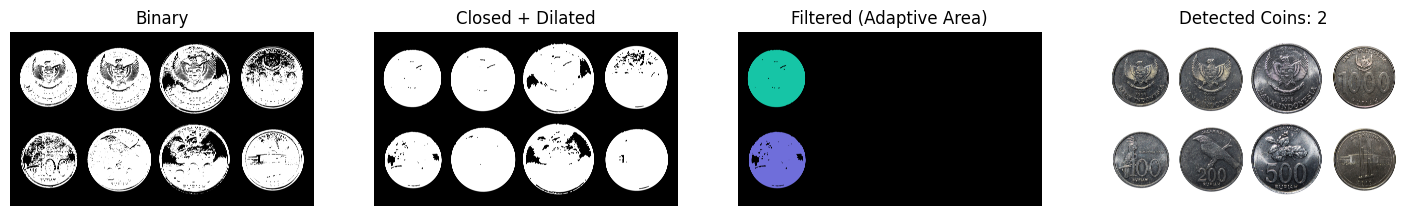

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

image_path = "tests/test1.png"
image = cv2.imread(image_path)
if image is None:
  raise FileNotFoundError("Gambar tidak ditemukan")

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (15,15), 0)
_, binary = cv2.threshold(blur, 120, 255, cv2.THRESH_BINARY_INV)

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15,15))
closed = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations=2)
dilated = cv2.dilate(closed, kernel, iterations=1)
final = cv2.medianBlur(dilated, 5)

def connected_components_dominant_v2(binary_img):
  img = (binary_img > 0).astype(np.uint8)
  h, w = img.shape
  label = np.zeros((h, w), dtype=np.int32)
  current_label = 0
  areas = []
  components = {}
  directions = [(-1,0),(1,0),(0,-1),(0,1),(-1,-1),(-1,1),(1,-1),(1,1)]

  for y in range(h):
    for x in range(w):
      if img[y,x] == 1 and label[y,x] == 0:
        current_label += 1
        stack = [(y,x)]
        pixels = []
        while stack:
          cy,cx = stack.pop()
          if label[cy,cx] == 0:
            label[cy,cx] = current_label
            pixels.append((cy,cx))
            for dy,dx in directions:
              ny,nx = cy+dy, cx+dx
              if 0 <= ny < h and 0 <= nx < w:
                if img[ny,nx] == 1 and label[ny,nx] == 0:
                  stack.append((ny,nx))
        area = len(pixels)
        areas.append(area)
        components[current_label] = pixels

  if not areas:
    return np.zeros_like(label), 0

  # --- Filter kasar pertama untuk buang noise kecil ---
  rough_min = np.percentile(areas, 60)  # ambil area di atas 60% (buang kecil)
  big_areas = [a for a in areas if a > rough_min]

  if not big_areas:
    return np.zeros_like(label), 0

  # Hitung rata-rata area besar sebagai dasar
  mean_area = np.mean(big_areas)
  min_area = mean_area * 0.5
  max_area = mean_area * 1.5

  filtered_label = np.zeros_like(label)
  kept = 0
  for lbl, pixels in components.items():
    area = len(pixels)
    if min_area <= area <= max_area:
      kept += 1
      for (y,x) in pixels:
        filtered_label[y,x] = lbl

  return filtered_label, kept

labels, coin_count = connected_components_dominant_v2(final)
print(f"Jumlah koin terdeteksi (area dominan adaptif): {coin_count}")

# Visualisasi
colored_label = np.zeros((*labels.shape, 3), dtype=np.uint8)
rng = np.random.default_rng(42)
for i in np.unique(labels):
  if i == 0: continue
  colored_label[labels == i] = rng.integers(0,255,3)

plt.figure(figsize=(18,12))
plt.subplot(1,4,1); plt.title("Binary"); plt.imshow(binary, cmap="gray"); plt.axis("off")
plt.subplot(1,4,2); plt.title("Closed + Dilated"); plt.imshow(final, cmap="gray"); plt.axis("off")
plt.subplot(1,4,3); plt.title("Filtered (Adaptive Area)"); plt.imshow(colored_label); plt.axis("off")
plt.subplot(1,4,4); plt.title(f"Detected Coins: {coin_count}"); plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)); plt.axis("off")
plt.show()